# Prepare data in monthly format


In [ ]:
from dask.distributed import Client,LocalCluster
from dask_jobqueue import PBSCluster

In [2]:
PROJECT = "dt6"

In [81]:
client.close()
cluster.close()

INFO:dask_jobqueue.pbs:Resource specification for PBS not set, initializing it to select=1:ncpus=24:mem=90GB


In [82]:
walltime = "00:10:00"
cores = 24
memory = str(4 * cores) + "GB"

cluster = PBSCluster(
    walltime=str(walltime),
    cores=cores,
    memory=str(memory),
    processes=cores,
    job_extra_directives=[
        "-q normal",
        "-P "+PROJECT,
        "-l ncpus="+str(cores),
        "-l mem="+str(memory),
        "-l storage=gdata/xp65+gdata/ob53+gdata/w42+scratch/w42+gdata/gb02+scratch/gb02+gdata/ng72+scratch/ng72+gdata/rt52+scratch/dt6"
    ],
    local_directory="$TMPDIR",
    job_directives_skip=["select"],
    log_directory="/scratch/w42/dr6273/tmp/logs"
)

INFO:dask_jobqueue.pbs:Resource specification for PBS not set, initializing it to select=1:ncpus=24:mem=90GB
ERROR:asyncio:Task exception was never retrieved
future: <Task finished name='Task-234065' coro=<Client._gather.<locals>.wait() done, defined at /g/data/xp65/public/apps/med_conda/envs/analysis3-26.01/lib/python3.11/site-packages/distributed/client.py:2384> exception=AllExit()>
Traceback (most recent call last):
  File "/g/data/xp65/public/apps/med_conda/envs/analysis3-26.01/lib/python3.11/site-packages/distributed/client.py", line 2393, in wait
    raise AllExit()
distributed.client.AllExit
ERROR:asyncio:Task exception was never retrieved
future: <Task finished name='Task-399647' coro=<Client._gather.<locals>.wait() done, defined at /g/data/xp65/public/apps/med_conda/envs/analysis3-26.01/lib/python3.11/site-packages/distributed/client.py:2384> exception=AllExit()>
Traceback (most recent call last):
  File "/g/data/xp65/public/apps/med_conda/envs/analysis3-26.01/lib/python3.11/s

In [83]:
cluster.scale(jobs=1)
client = Client(cluster)

INFO:dask_jobqueue.pbs:Resource specification for PBS not set, initializing it to select=1:ncpus=24:mem=90GB


In [84]:
client#.restart()

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.6.124.20:36027,Workers: 0
Dashboard: /proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [1]:
import xarray as xr
import pandas as pd
import numpy as np

In [2]:
%cd /g/data/w42/dr6273/work/seasonal_energy/

import functions as fn

/g/data/w42/dr6273/work/seasonal_energy


## Load data

In [3]:
regions = ["NSW", "QLD", "VIC", "SA", "TAS"]

In [4]:
path_power = "/g/data/w42/dr6273/work/projects/Aus_energy/production_metrics/"
path_scratch = "/scratch/dt6/dr6273/data/energy/"

#### Wind and solar power

For installed farms/facilities
- Using van der Wiel et al (2019) wind turbine / solar panel fit to obtain capacity factors
- Wind facilities from OpenNEM as on July 2024

In [9]:
# wind_power = xr.open_mfdataset(
#     path_power + "wind/power/wind_power_state_van_der_Wiel_era5_hourly_1940-2023.nc"
# )
# wind_power = wind_power.sel(region=regions)

In [10]:
# solar_power = xr.open_mfdataset(
#     path_power + "solar/power/solar_power_state_van_der_Wiel_era5_hourly_1940-2023.nc"
# )
# solar_power = solar_power.sel(region=regions)

For REZs
- Current/planned generation capacities. These sometimes underestimate observed power (i.e. from installed farms) because it spreads the capacity around the REZ, rather than being loaded on a single grid cell.

In [11]:
# wind_rez_current = xr.open_mfdataset(
#     path_power + "REZ_power_existing_wind_van_der_Wiel_era5_hourly_1940-2023.nc"
# )

In [12]:
wind_rez_2025 = xr.open_mfdataset(
    path_scratch + "REZ_power_wind_medium_Existing_wind_van_der_Wiel_era5_hourly_1940-2023.nc"
)

In [13]:
# # Pad 7 hours at beginning as missing radiation data here
# solar_rez_current = xr.open_mfdataset(
#     path_power + "REZ_power_existing_solar_van_der_Wiel_era5_hourly_1940-2023.nc"
# ).pad({"time": (7,0)})
# solar_rez_current["time"] = wind_rez_current["time"]

In [14]:
# Pad 7 hours at beginning as missing radiation data here
solar_rez_2025 = xr.open_mfdataset(
    path_scratch + "REZ_power_solarpv_Existing_solar_van_der_Wiel_era5_hourly_1940-2023.nc"
).pad({"time": (7,0)})
solar_rez_2025["time"] = wind_rez_2025["time"]

Future generation capacities

In [15]:
# # Step-change 2029-30 labelled as SC30
# wind_rez_SC30 = xr.open_mfdataset(
#     path_power + "REZ_power_step_change_wind_2029-30_van_der_Wiel_era5_hourly_1940-2023.nc"
# )

In [16]:
# Step-change 2029-30 labelled as SC30
wind_rez_SC30 = xr.open_mfdataset(
    path_scratch + "REZ_power_wind_medium_Step_change_wind_2029-30_van_der_Wiel_era5_hourly_1940-2023.nc"
)

In [17]:
# solar_rez_SC30 = xr.open_mfdataset(
#     path_power + "REZ_power_step_change_solar_2029-30_van_der_Wiel_era5_hourly_1940-2023.nc"
# ).pad({"time": (7,0)})
# solar_rez_SC30["time"] = wind_rez_current["time"]

In [18]:
solar_rez_SC30 = xr.open_mfdataset(
    path_scratch + "REZ_power_solarpv_Step_change_solar_2029-30_van_der_Wiel_era5_hourly_1940-2023.nc"
).pad({"time": (7,0)})
solar_rez_SC30["time"] = wind_rez_2025["time"]

In [19]:
# # Step-change 2039-40 labelled as SC40
# wind_rez_SC40 = xr.open_mfdataset(
#     path_power + "REZ_power_step_change_wind_2039-40_van_der_Wiel_era5_hourly_1940-2023.nc"
# )

In [20]:
# Step-change 2039-40 labelled as SC40
wind_rez_SC40 = xr.open_mfdataset(
    path_scratch + "REZ_power_wind_medium_Step_change_wind_2039-40_van_der_Wiel_era5_hourly_1940-2023.nc"
)

In [21]:
# solar_rez_SC40 = xr.open_mfdataset(
#     path_power + "REZ_power_step_change_solar_2039-40_van_der_Wiel_era5_hourly_1940-2023.nc"
# ).pad({"time": (7,0)})
# solar_rez_SC40["time"] = wind_rez_current["time"]

In [22]:
solar_rez_SC40 = xr.open_mfdataset(
    path_scratch + "REZ_power_solarpv_Step_change_solar_2039-40_van_der_Wiel_era5_hourly_1940-2023.nc"
).pad({"time": (7,0)})
solar_rez_SC40["time"] = wind_rez_2025["time"]

In [23]:
# # Step-change 2049-50 labelled as SC50
# wind_rez_SC50 = xr.open_mfdataset(
#     path_power + "REZ_power_step_change_wind_2049-50_van_der_Wiel_era5_hourly_1940-2023.nc"
# )

In [24]:
# Step-change 2049-50 labelled as SC50
wind_rez_SC50 = xr.open_mfdataset(
    path_scratch + "REZ_power_wind_medium_Step_change_wind_2049-50_van_der_Wiel_era5_hourly_1940-2023.nc"
)

In [25]:
# solar_rez_SC50 = xr.open_mfdataset(
#     path_power + "REZ_power_step_change_solar_2049-50_van_der_Wiel_era5_hourly_1940-2023.nc"
# ).pad({"time": (7,0)})
# solar_rez_SC50["time"] = wind_rez_current["time"]

In [26]:
solar_rez_SC50 = xr.open_mfdataset(
    path_scratch + "REZ_power_solarpv_Step_change_solar_2049-50_van_der_Wiel_era5_hourly_1940-2023.nc"
).pad({"time": (7,0)})
solar_rez_SC50["time"] = wind_rez_2025["time"]

We have some artificial scenarios that add some generation capacity to a particular REZ

In [27]:
wind_rez_Q1 = xr.open_mfdataset(
    "/scratch/dt6/dr6273/data/energy/" + "REZ_power_wind_medium_artificial_Q1_wind_2049-50_van_der_Wiel_era5_hourly_1940-2023.nc"
)

In [28]:
wind_rez_Q2 = xr.open_mfdataset(
    "/scratch/dt6/dr6273/data/energy/" + "REZ_power_wind_medium_artificial_Q2_wind_2049-50_van_der_Wiel_era5_hourly_1940-2023.nc"
)

In [29]:
wind_rez_Q5 = xr.open_mfdataset(
    "/scratch/dt6/dr6273/data/energy/" + "REZ_power_wind_medium_artificial_Q5_wind_2049-50_van_der_Wiel_era5_hourly_1940-2023.nc"
)

In [30]:
wind_rez_Q6 = xr.open_mfdataset(
    "/scratch/dt6/dr6273/data/energy/" + "REZ_power_wind_medium_artificial_Q6_wind_2049-50_van_der_Wiel_era5_hourly_1940-2023.nc"
)

In [31]:
wind_rez_N10 = xr.open_mfdataset(
    "/scratch/dt6/dr6273/data/energy/" + "REZ_power_wind_medium_artificial_N10_wind_2049-50_van_der_Wiel_era5_hourly_1940-2023.nc"
)

In [131]:
wind_rez_T3 = xr.open_mfdataset(
    "/scratch/dt6/dr6273/data/energy/" + "REZ_power_wind_medium_artificial_T3_wind_2049-50_van_der_Wiel_era5_hourly_1940-2023.nc"
)

In [33]:
solar_rez_V5 = xr.open_mfdataset(
    "/scratch/dt6/dr6273/data/energy/" + "REZ_power_solarpv_artificial_V5_solar_2049-50_van_der_Wiel_era5_hourly_1940-2023.nc"
).pad({"time": (7,0)})
solar_rez_V5["time"] = wind_rez_2025["time"]

We also use the power from farms outside the REZs, and add this to the REZ power

In [34]:
# wind_outside_rez = xr.open_mfdataset(
#     path_power + "site_outside_REZ_power_existing_wind_van_der_Wiel_era5_hourly_1940-2023.nc"
# ).astype("float32")

In [35]:
# solar_outside_rez = xr.open_mfdataset(
#     path_power + "site_outside_REZ_power_existing_solar_van_der_Wiel_era5_hourly_1940-2023.nc"
# ).astype("float32").pad({"time": (7,0)})
# solar_outside_rez["time"] = wind_outside_rez["time"]

Add these together

In [36]:
def get_REZ_for_state(ds, state, rez_dim="REZ"):
    """
    Return list of REZ names for state
    
    ds: dataset with REZ dimension
    state: str, code or for state e.g. NSW, SA
    """
    return [i for i in ds[rez_dim].values if i[0] == state[0]]

In [37]:
def sum_REZ_power_for_states(ds, states=["NSW", "QLD", "VIC", "SA", "TAS"], rez_dim="region"):
    """
    Return array of ds summed for each REZ in each state
    
    ds: dataset with REZ dimension
    states: list, of strings of states
    """
    da_list = []
    for state in states:
        r = get_REZ_for_state(ds, state, rez_dim=rez_dim)
        da = ds.sel({rez_dim: r}).sum(rez_dim).expand_dims({"region": [state]})
        da_list.append(da)
    return xr.concat(da_list, dim="region")

In [38]:
# wind_rez_current = sum_REZ_power_for_states(wind_rez_current, rez_dim="REZ") + wind_outside_rez

In [39]:
wind_rez_current = sum_REZ_power_for_states(wind_rez_2025)

In [40]:
# solar_rez_current = sum_REZ_power_for_states(solar_rez_current) + solar_outside_rez

In [41]:
solar_rez_current = sum_REZ_power_for_states(solar_rez_2025)

In [42]:
wind_rez_SC30 = sum_REZ_power_for_states(wind_rez_SC30)# + wind_outside_rez

In [43]:
solar_rez_SC30 = sum_REZ_power_for_states(solar_rez_SC30)# + solar_outside_rez

In [44]:
wind_rez_SC40 = sum_REZ_power_for_states(wind_rez_SC40)# + wind_outside_rez

In [45]:
solar_rez_SC40 = sum_REZ_power_for_states(solar_rez_SC40)# + solar_outside_rez

In [46]:
wind_rez_SC50 = sum_REZ_power_for_states(wind_rez_SC50)# + wind_outside_rez

In [47]:
solar_rez_SC50 = sum_REZ_power_for_states(solar_rez_SC50)# + solar_outside_rez

In [48]:
wind_rez_Q1 = sum_REZ_power_for_states(wind_rez_Q1)

In [49]:
wind_rez_Q2 = sum_REZ_power_for_states(wind_rez_Q2)

In [50]:
wind_rez_Q5 = sum_REZ_power_for_states(wind_rez_Q5)

In [51]:
wind_rez_Q6 = sum_REZ_power_for_states(wind_rez_Q6)

In [52]:
wind_rez_N10 = sum_REZ_power_for_states(wind_rez_N10)

In [132]:
wind_rez_T3 = sum_REZ_power_for_states(wind_rez_T3)

In [54]:
solar_rez_V5 = sum_REZ_power_for_states(solar_rez_V5)

Hack add TAS for solar to keep it same format as site power.

In [55]:
# solar_tas = xr.DataArray(
#     np.zeros(len(solar_rez_current.time)),
#     dims=["time"],
#     coords={"time": solar_rez_current.time}
# ).expand_dims({"region": ["TAS"]})

In [56]:
# solar_rez_current = xr.concat([solar_rez_current.power, solar_tas], "region").to_dataset(name="power")

In [57]:
# solar_rez_SC30 = xr.concat([solar_rez_SC30.power, solar_tas], "region").to_dataset(name="power")

In [58]:
# solar_rez_SC40 = xr.concat([solar_rez_SC40.power, solar_tas], "region").to_dataset(name="power")

In [59]:
# solar_rez_SC50 = xr.concat([solar_rez_SC50.power, solar_tas], "region").to_dataset(name="power")

In [60]:
# solar_rez_V5 = xr.concat([solar_rez_V5.power, solar_tas], "region").to_dataset(name="power")

#### Add scale factors computed by comparing REZ + sites outside REZs with observed AEMO generation.
See this notebook: https://github.com/dougrichardson/power_models/blob/main/12_compare_power.ipynb

In [61]:
# wind_scale_factors = np.array([2.02321105, 1.25639303, 1.13581679, 1.72883961, 1.47794378])

In [62]:
# solar_scale_factors = np.array([0.6638736 , 0.95382913, 0.54762614, 0.55381373, np.nan])

In [63]:
# solar_rez_SC30 = solar_rez_SC30.assign_coords(scale_factor_2023=("region", solar_scale_factors))

In [64]:
# wind_rez_SC40 = wind_rez_SC40.assign_coords(scale_factor_2023=("region", wind_scale_factors))

In [65]:
# solar_rez_SC40 = solar_rez_SC40.assign_coords(scale_factor_2023=("region", solar_scale_factors))

In [66]:
# wind_rez_SC50 = wind_rez_SC50.assign_coords(scale_factor_2023=("region", wind_scale_factors))

In [67]:
# solar_rez_SC50 = solar_rez_SC50.assign_coords(scale_factor_2023=("region", solar_scale_factors))

In [68]:
# wind_rez_N10 = wind_rez_N10.assign_coords(scale_factor_2023=("region", wind_scale_factors))

In [69]:
# import matplotlib.pyplot as plt

# fig, ax = plt.subplots(2, 1)

# wind_power.power.sum("region").resample(time="1YS").mean().plot(ax=ax[0], label="Sites")
# wind_rez_current.power.sum("region").resample(time="1YS").mean().plot(ax=ax[0], label="REZ and extra sites (current)")
# wind_rez_SC30.power.sum("region").resample(time="1YS").mean().plot(ax=ax[0], label="REZ and extra sites (SC 30)")
# wind_rez_SC40.power.sum("region").resample(time="1YS").mean().plot(ax=ax[0], label="REZ and extra sites (SC 40)")
# wind_rez_SC50.power.sum("region").resample(time="1YS").mean().plot(ax=ax[0], label="REZ and extra sites (SC 50)")
# ax[0].legend()
# ax[0].set_title("NEM wind")

# solar_power.power.sum("region").resample(time="1YS").mean().plot(ax=ax[1], label="Sites")
# solar_rez_current.power.sum("region").resample(time="1YS").mean().plot(ax=ax[1], label="REZ and extra sites (current)")
# solar_rez_SC30.power.sum("region").resample(time="1YS").mean().plot(ax=ax[1], label="REZ and extra sites (SC30)")
# solar_rez_SC40.power.sum("region").resample(time="1YS").mean().plot(ax=ax[1], label="REZ and extra sites (SC40)")
# solar_rez_SC50.power.sum("region").resample(time="1YS").mean().plot(ax=ax[1], label="REZ and extra sites (SC50)")
# ax[1].set_title("NEM solar")
# plt.tight_layout()

#### Demand predictions
- Random forest predictions from demand data trained over 2010-16.
- Extrapolated using ERA5 data.
- Exclude days when the predictors are outside the range of the training period.

In [70]:
path_demand = "/g/data/w42/dr6273/work/projects/Aus_energy/model_results/"

In [71]:
_demand = []
for r in regions:
    dem = pd.read_csv(
        path_demand + "extrapolated/random_forest/extrapolated_NEM_" + r + "_pop_dens_mask_NOWEEKEND_NOXMAS_training2010-2016_test1940-2023_nFeatures-parsimonious_detrended.csv",
        index_col=0,
        usecols=["Unnamed: 0", "prediction"],
        parse_dates=True
    )
    dem = xr.Dataset.from_dataframe(dem)
    dem = dem.rename({"index": "time", "prediction": "demand"})
    dem = dem.assign_coords({"time": pd.to_datetime(dem["time"])})
    dem = dem["demand"]
    dem = dem.expand_dims({"region": [r]})
    _demand.append(dem)
    
_demand = xr.concat(_demand, dim="region")
# Start from Feb 1940 as Jan 1940 is incomplete
_demand = _demand.sel(time=slice("1940-02-01", None))

#### Demand observations

- AEMO observations, detrended using LOESS

In [72]:
aemo_demand = xr.open_mfdataset(
    "/g/data/w42/dr6273/work/projects/Aus_energy/data/energy_demand/daily_demand_2010-2020_stl.nc"
)

In [73]:
aemo_demand = aemo_demand.sel(time=slice("2010", "2019")) # Exclude 2020 because of COVID

### Demand projections
AEMO projected demand. Use this to scale demand predictions for future scenarios. First scale demand predictions to 2025 from ESOO. The model used for predictions was trained on 2010-17, which had higher-than-average demand, so we scale to 2023.

https://aemo.com.au/energy-systems/electricity/national-electricity-market-nem/nem-forecasting-and-planning/forecasting-and-planning-data/electricity-forecasting-data-portal

In [74]:
def load_ESOO_dem():
    """
    Load and process projected demand
    """
    df_list = []
    for region in ["NEM", "QLD", "NSW", "VIC", "SA", "TAS"]:
        df = pd.read_csv(
            "/g/data/w42/dr6273/work/projects/Aus_energy/data/energy_demand/" + region + "_operational_sentout.csv",
        )
        # Remove Rooftop PV, Small non-scheduled and energy efficiency
        df = df.loc[df["Category"] != "Rooftop PV"]
        df = df.loc[df["Category"] != "Small Non Scheduled Generation"]
        df = df.loc[df["Category"] != "Energy Efficiency"]
        
        df = df.groupby("Year")["Value"].sum()
        df = df.loc[[2025, 2030, 2040, 2050]]
        df = pd.DataFrame(df.values, index=df.index, columns=[region])
        df_list.append(df)
    return pd.concat(df_list, axis=1)

In [75]:
def load_isp_dem():
    """
    Compute operational demand for each region using ISP data
    """
    regions = ['NEM', 'NSW', 'QLD', 'VIC', 'SA', 'TAS']
    df_list = []
    for r in regions:
        df = pd.read_csv(
            r + "-aemo2024-step_change-CDP14-energy.csv",
            index_col=0,
            parse_dates=True,
            na_values="—"
        )
        df = df.drop("Solar (Rooftop)", axis=1)
        if r != "NEM":
            df = df.drop("Imports", axis=1)
        df = df.sum(axis=1)
        df_list.append(df)
    df = pd.concat(df_list, axis=1)
    df.columns = regions
    return df

In [76]:
proj_dem = load_isp_dem()

/jobfs/149841370.gadi-pbs/ipykernel_392942/4198711422.py:8: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv(
/jobfs/149841370.gadi-pbs/ipykernel_392942/4198711422.py:8: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv(
/jobfs/149841370.gadi-pbs/ipykernel_392942/4198711422.py:8: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv(
/jobfs/149841370.gadi-pbs/ipykernel_392942/4198711422.py:8: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as

<AxesSubplot: xlabel='date'>

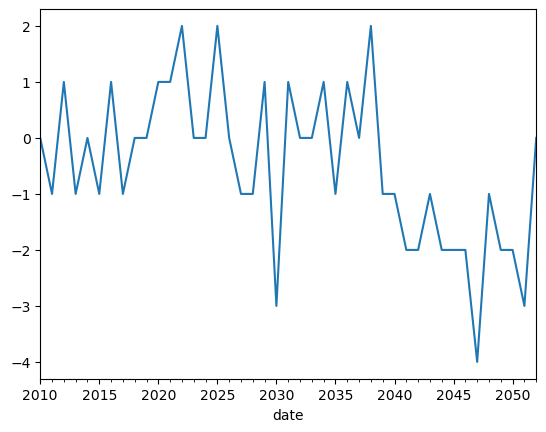

In [77]:
# Difference between summing all regions with NEM.
#  This is due to including Imports for each region. We want to keep Imports as it represents demand.
(proj_dem.drop("NEM", axis=1).sum(axis=1) - proj_dem["NEM"]).plot()

In [77]:
# proj_dem = load_ESOO_dem()

In [78]:
# proj_dem.plot()

Projected 2023 demand from ESOO 2022 (same portal)

In [79]:
# proj_dem_2023 = pd.DataFrame(
#     np.array([180.25, 51.5, 63.79, 42.02, 11.81, 11.13]).reshape(1, -1),
#     index=[2023],
#     columns=proj_dem.columns
# )

In [80]:
# proj_dem = pd.concat([proj_dem_2023, proj_dem], axis=0)

In [81]:
proj_dem = proj_dem.loc[["2025", "2030", "2040", "2050"]]
proj_dem

,NEM,NSW,QLD,VIC,SA,TAS
date,,,,,,
2025-01-01,184.0,70.0,53.0,41.0,11.0,11.0
2030-01-01,216.0,77.0,64.0,43.0,14.0,15.0
2040-01-01,291.0,90.0,90.0,75.0,15.0,20.0
2050-01-01,340.0,101.0,117.0,75.0,23.0,22.0


Demand predictions 2023

In [82]:
# est_dem_2023 = np.array(
#     [demand.sel(time="2023").sum("time").sum().values] + list(demand.sel(time="2023").sum("time").values)
# ) / 1e6
# est_dem_2023

In [83]:
# Total annual demand, averaged over all years
#. Exclude 1940 as no values at beginning of that year.
est_dem = np.array(
    [
        _demand.sel(time=slice("1941", None)).sum("region").resample(time="1YS").sum().mean("time").values
    ] + \
    list(
        _demand.sel(
            time=slice("1941", None),
        ).resample(time="1YS").sum().mean("time").values
    )
) / 1e6

In [84]:
est_dem

array([198.89035249,  73.56595406,  54.4333846 ,  48.11915389,
        12.8011361 ,   9.97072385])

Now scale estimates to projected

In [85]:
# # Future demand scaled by present (2024-25) demand
# proj_scaled = proj_dem / est_dem_2023

In [86]:
# proj_scaled

In [87]:
# Future demand scaled by present (2024-25) demand
proj_scaled = proj_dem - est_dem
proj_scaled

,NEM,NSW,QLD,VIC,SA,TAS
date,,,,,,
2025-01-01,-14.890352,-3.565954,-1.433385,-7.119154,-1.801136,1.029276
2030-01-01,17.109648,3.434046,9.566615,-5.119154,1.198864,5.029276
2040-01-01,92.109648,16.434046,35.566615,26.880846,2.198864,10.029276
2050-01-01,141.109648,27.434046,62.566615,26.880846,10.198864,12.029276


In [88]:
# Convert from TWh to MWh
proj_scaled = proj_scaled * 1e6

In [89]:
proj_scaled

,NEM,NSW,QLD,VIC,SA,TAS
date,,,,,,
2025-01-01,-1.489035e+07,-3.565954e+06,-1.433385e+06,-7.119154e+06,-1.801136e+06,1.029276e+06
2030-01-01,1.710965e+07,3.434046e+06,9.566615e+06,-5.119154e+06,1.198864e+06,5.029276e+06
2040-01-01,9.210965e+07,1.643405e+07,3.556662e+07,2.688085e+07,2.198864e+06,1.002928e+07
2050-01-01,1.411096e+08,2.743405e+07,6.256662e+07,2.688085e+07,1.019886e+07,1.202928e+07


In [90]:
# Convert to xarray
proj_scaled_da = proj_scaled.to_xarray().to_array()
proj_scaled_da = proj_scaled_da.rename({"variable": "region", "date": "Year"})
proj_scaled_da
# proj_scaled_da = proj_scaled_da.sel(region=aemo_demand.region.values)

<xarray.DataArray (region: 6, Year: 4)> Size: 192B
array([[-1.48903525e+07,  1.71096475e+07,  9.21096475e+07,
         1.41109648e+08],
       [-3.56595406e+06,  3.43404594e+06,  1.64340459e+07,
         2.74340459e+07],
       [-1.43338460e+06,  9.56661540e+06,  3.55666154e+07,
         6.25666154e+07],
       [-7.11915389e+06, -5.11915389e+06,  2.68808461e+07,
         2.68808461e+07],
       [-1.80113610e+06,  1.19886390e+06,  2.19886390e+06,
         1.01988639e+07],
       [ 1.02927615e+06,  5.02927615e+06,  1.00292761e+07,
         1.20292761e+07]])
Coordinates:
  * Year     (Year) datetime64[ns] 32B 2025-01-01 2030-01-01 ... 2050-01-01
  * region   (region) object 48B 'NEM' 'NSW' 'QLD' 'VIC' 'SA' 'TAS'

In [91]:
# # Convert to xarray
# proj_scaled_da = proj_scaled.to_xarray().to_array()
# proj_scaled_da = proj_scaled_da.rename({"variable": "region", "index": "Year"})
# proj_scaled_da
# # proj_scaled_da = proj_scaled_da.sel(region=aemo_demand.region.values)

### Monthly means

In [92]:
# def scale_generation(ds):
#     """
#     Multiply ds by the scale factor
#     """
#     scale = ds["scale_factor_2023"]
#     return ds * scale

In [93]:
def add_NEM(ds):
    """
    Sum power for states and return new array
    """
    return ds["power"].sum("region").expand_dims({"region": ["NEM"]}).assign_coords({"scale_factor_2023": 0})

In [94]:
def monthly_total(ds):
    """
    Compute monthly sum
    """
    return ds.resample(time="1MS").sum()

In [95]:
def write_monthly(ds, name):
    """
    Write monthly data to file.
    
    ds: ds to write
    name: str, filename
    """
    ds.to_netcdf(
        "/g/data/w42/dr6273/work/projects/Aus_energy/monthly_data/" + name + ".nc",
        mode="w"
    )

In [96]:
def scale_and_write_monthly(ds, ds_name, write_fp, scale=False):
    """
    Write monthly averages of ds, after scaling and adding NEM as a region.
    
    ds: dataset
    ds_name: str, variable name to add to dataset
    write_fp: str, filename
    scale: bool, whether or not to scale
    """
    if scale:
        ds_scaled = scale_generation(ds)
    else:
        ds_scaled = ds.copy()
        
    ds_NEM = add_NEM(ds_scaled)
    ds_scaled = xr.concat([ds_NEM, ds_scaled[ds_name]], dim="region").to_dataset(name=ds_name)
    
    ds_monthly = monthly_total(ds_scaled)
    ds_monthly[ds_name + "_detrended"] = fn.detrend_dim(ds_monthly[ds_name], "time")
    
    write_monthly(ds_monthly, write_fp)
    
    # return ds_monthly

#### Wind

In [97]:
# scale_and_write_monthly(wind_power, "power", "wind_power_state_van_der_Wiel_era5_monthly_1940-2023", scale=False)

In [98]:
scale_and_write_monthly(wind_rez_current, "power", "wind_power_REZ_current_state_van_der_Wiel_era5_monthly_1940-2023")

In [99]:
scale_and_write_monthly(wind_rez_SC30, "power", "wind_power_REZ_step_change_2029-30_state_van_der_Wiel_era5_monthly_1940-2023")

In [100]:
scale_and_write_monthly(wind_rez_SC40, "power", "wind_power_REZ_step_change_2039-40_state_van_der_Wiel_era5_monthly_1940-2023")

In [101]:
scale_and_write_monthly(wind_rez_SC50, "power", "wind_power_REZ_step_change_2049-50_state_van_der_Wiel_era5_monthly_1940-2023")

In [102]:
scale_and_write_monthly(wind_rez_Q1, "power", "wind_power_REZ_artificial_Q1_2049-50_state_van_der_Wiel_era5_monthly_1940-2023")

In [103]:
scale_and_write_monthly(wind_rez_Q2, "power", "wind_power_REZ_artificial_Q2_2049-50_state_van_der_Wiel_era5_monthly_1940-2023")

In [104]:
scale_and_write_monthly(wind_rez_Q5, "power", "wind_power_REZ_artificial_Q5_2049-50_state_van_der_Wiel_era5_monthly_1940-2023")

In [105]:
scale_and_write_monthly(wind_rez_Q6, "power", "wind_power_REZ_artificial_Q6_2049-50_state_van_der_Wiel_era5_monthly_1940-2023")

In [106]:
scale_and_write_monthly(wind_rez_N10, "power", "wind_power_REZ_artificial_N10_2049-50_state_van_der_Wiel_era5_monthly_1940-2023")

In [133]:
scale_and_write_monthly(wind_rez_T3, "power", "wind_power_REZ_artificial_T2_2049-50_state_van_der_Wiel_era5_monthly_1940-2023")

#### Solar

In [ ]:
# scale_and_write_monthly(solar_power, "power", "solar_power_state_van_der_Wiel_era5_monthly_1940-2023", scale=False)

In [ ]:
scale_and_write_monthly(solar_rez_current, "power", "solar_power_REZ_current_state_van_der_Wiel_era5_monthly_1940-2023")

In [ ]:
scale_and_write_monthly(solar_rez_SC30, "power", "solar_power_REZ_step_change_2029-30_state_van_der_Wiel_era5_monthly_1940-2023")

In [ ]:
scale_and_write_monthly(solar_rez_SC40, "power", "solar_power_REZ_step_change_2039-40_state_van_der_Wiel_era5_monthly_1940-2023")

In [ ]:
scale_and_write_monthly(solar_rez_SC50, "power", "solar_power_REZ_step_change_2049-50_state_van_der_Wiel_era5_monthly_1940-2023")

In [158]:
scale_and_write_monthly(solar_rez_V5, "power", "solar_power_REZ_artificial_V5_2049-50_state_van_der_Wiel_era5_monthly_1940-2023")

#### Demand

Do this manually as functions don't generalise well :(

In [108]:
_NEM = _demand.sum("region").expand_dims({"region": ["NEM"]})
demand = xr.concat([_NEM, _demand], dim="region")

In [109]:
# Add coords of scaling factors for future daily demand
demand = demand.assign_coords(
    scale_factor_2025=("region", proj_scaled_da.sel(Year="2025").values.reshape(-1) / 365.25),
    scale_factor_2030=("region", proj_scaled_da.sel(Year="2030").values.reshape(-1) / 365.25),
    scale_factor_2040=("region", proj_scaled_da.sel(Year="2040").values.reshape(-1) / 365.25),
    scale_factor_2050=("region", proj_scaled_da.sel(Year="2050").values.reshape(-1) / 365.25)
)

Write monthly demand

In [110]:
demand_monthly = monthly_total(demand).to_dataset(name="demand")
demand_monthly["demand_detrended"] = fn.detrend_dim(demand_monthly.demand, "time")

In [111]:
# Add coords of scaling factors for future monthly demand
demand_monthly = demand_monthly.assign_coords(
    scale_factor_2025=("region", proj_scaled_da.sel(Year="2025").values.reshape(-1) / 12),
    scale_factor_2030=("region", proj_scaled_da.sel(Year="2030").values.reshape(-1) / 12),
    scale_factor_2040=("region", proj_scaled_da.sel(Year="2040").values.reshape(-1) / 12),
    scale_factor_2050=("region", proj_scaled_da.sel(Year="2050").values.reshape(-1) / 12)
)

In [138]:
write_monthly(
    demand_monthly + demand_monthly.scale_factor_2025,
    "demand_state_training2010-16_extrapolate1940-2023"
)

In [139]:
write_monthly(
    demand_monthly + demand_monthly.scale_factor_2030,
    "demand_state_step_change_2029-30_training2010-16_extrapolate1940-2023"
)

In [140]:
write_monthly(
    demand_monthly + demand_monthly.scale_factor_2040,
    "demand_state_step_change_2039-40_training2010-16_extrapolate1940-2023"
)

In [141]:
write_monthly(
    demand_monthly + demand_monthly.scale_factor_2050,
    "demand_state_step_change_2049-50_training2010-16_extrapolate1940-2023"
)

#### Shortfall

In [112]:
def shortfall_scale_and_write_monthly(wind, solar, demand, write_fp, scale=False):
    """
    Write monthly averages of shortfall, after scaling and adding NEM as a region.
    
    ds: dataset
    ds_name: str, variable name to add to dataset
    write_fp: str, filename
    """
    # Scale and add NEM
    if scale:
        wind_scaled = scale_generation(wind)
    else:
        wind_scaled = wind.copy()
    wind_NEM = add_NEM(wind_scaled)
    wind_scaled = xr.concat([wind_NEM, wind_scaled["power"]], dim="region").to_dataset(name="power")
    
    if scale:
        solar_scaled = scale_generation(solar)
    else:
        solar_scaled = solar.copy()
    solar_NEM = add_NEM(solar_scaled)
    solar_scaled = xr.concat([solar_NEM, solar_scaled["power"]], dim="region").to_dataset(name="power")
    
    # _NEM_demand = demand.sum("region").expand_dims({"region": ["NEM"]})
    # demand = xr.concat([_NEM_demand, demand], dim="region")
    
    # Coarsen to daily
    wind_daily = wind_scaled.coarsen(time=24).sum()
    solar_daily = solar_scaled.coarsen(time=24).sum()
    
    # Floor the time of day
    wind_daily["time"] = wind_daily["time"].dt.floor("D")
    solar_daily["time"] = solar_daily["time"].dt.floor("D")
    
    # Compute shortfall
    shortfall = demand - wind_daily - solar_daily
    
    # Monthly total
    shortfall_monthly = monthly_total(shortfall).rename({"power": "shortfall"})
    shortfall_monthly["shortfall_detrended"] = fn.detrend_dim(shortfall_monthly.shortfall, "time")
    
    write_monthly(shortfall_monthly, write_fp)
    
    # return shortfall_monthly

In [113]:
# # Sites
# shortfall_scale_and_write_monthly(
#     wind_power, solar_power, demand, "shortfall_state_van_der_Wiel_training2010-16_extrapolate1940-2023"
# )

In [114]:
# REZ current
shortfall_scale_and_write_monthly(
    wind_rez_current,
    solar_rez_current,
    demand + demand.scale_factor_2025,
    "shortfall_REZ_current_state_van_der_Wiel_training2010-16_extrapolate1940-2023"
)

In [115]:
# REZ Step change 2029-30
shortfall_scale_and_write_monthly(
    wind_rez_SC30,
    solar_rez_SC30,
    demand + demand.scale_factor_2030, 
    "shortfall_REZ_step_change_2029-30_state_van_der_Wiel_training2010-16_extrapolate1940-2023"
)

In [116]:
# REZ Step change 2039-40
shortfall_scale_and_write_monthly(
    wind_rez_SC40,
    solar_rez_SC40,
    demand + demand.scale_factor_2040, 
    "shortfall_REZ_step_change_2039-40_state_van_der_Wiel_training2010-16_extrapolate1940-2023"
)

In [117]:
# REZ Step change 2049-50
shortfall_scale_and_write_monthly(
    wind_rez_SC50,
    solar_rez_SC50,
    demand + demand.scale_factor_2050, 
    "shortfall_REZ_step_change_2049-50_state_van_der_Wiel_training2010-16_extrapolate1940-2023"
)

In [118]:
# REZ Artificial Q1
shortfall_scale_and_write_monthly(
    wind_rez_Q1,
    solar_rez_SC50,
    demand + demand.scale_factor_2050, 
    "shortfall_REZ_artificial_Q1_2049-50_state_van_der_Wiel_training2010-16_extrapolate1940-2023"
)

In [ ]:
# REZ Artificial Q2
shortfall_scale_and_write_monthly(
    wind_rez_Q2,
    solar_rez_SC50,
    demand + demand.scale_factor_2050, 
    "shortfall_REZ_artificial_Q2_2049-50_state_van_der_Wiel_training2010-16_extrapolate1940-2023"
)

In [ ]:
# REZ Artificial Q5
shortfall_scale_and_write_monthly(
    wind_rez_Q5,
    solar_rez_SC50,
    demand + demand.scale_factor_2050, 
    "shortfall_REZ_artificial_Q5_2049-50_state_van_der_Wiel_training2010-16_extrapolate1940-2023"
)

In [ ]:
# REZ Artificial Q6
shortfall_scale_and_write_monthly(
    wind_rez_Q6,
    solar_rez_SC50,
    demand + demand.scale_factor_2050, 
    "shortfall_REZ_artificial_Q6_2049-50_state_van_der_Wiel_training2010-16_extrapolate1940-2023"
)

In [ ]:
# REZ Artificial N10
shortfall_scale_and_write_monthly(
    wind_rez_N10,
    solar_rez_SC50,
    demand + demand.scale_factor_2050, 
    "shortfall_REZ_artificial_N10_2049-50_state_van_der_Wiel_training2010-16_extrapolate1940-2023"
)

In [135]:
# REZ Artificial T3
shortfall_scale_and_write_monthly(
    wind_rez_T3,
    solar_rez_SC50,
    demand + demand.scale_factor_2050, 
    "shortfall_REZ_artificial_T3_2049-50_state_van_der_Wiel_training2010-16_extrapolate1940-2023"
)

In [126]:
# REZ Artificial V5 solar
shortfall_scale_and_write_monthly(
    wind_rez_SC50,
    solar_rez_V5,
    demand + demand.scale_factor_2050, 
    "shortfall_REZ_artificial_V5_2049-50_state_van_der_Wiel_training2010-16_extrapolate1940-2023"
)

#### Observed demand (AEMO)

In [26]:
aemo_montly = monthly_total(aemo_demand)
write_monthly(aemo_monthly, "aemo_demand_2010-19_detrended")

## Capacity factors and wind speed

- Gridded, not by state.
- Hourly to monthly

In [5]:
from dask.distributed import Client,LocalCluster
from dask_jobqueue import PBSCluster

In [6]:
PROJECT = "dt6"

In [53]:
client.close()
cluster.close()

INFO:dask_jobqueue.pbs:Resource specification for PBS not set, initializing it to select=1:ncpus=24:mem=90GB


In [54]:
walltime = "00:10:00"
cores = 24
memory = str(4 * cores) + "GB"

cluster = PBSCluster(
    walltime=str(walltime),
    cores=cores,
    memory=str(memory),
    processes=cores,
    job_extra_directives=[
        "-q normal",
        "-P "+PROJECT,
        "-l ncpus="+str(cores),
        "-l mem="+str(memory),
        "-l storage=gdata/xp65+gdata/ob53+gdata/w42+scratch/w42+gdata/gb02+scratch/gb02+gdata/ng72+scratch/ng72+gdata/rt52+scratch/dt6"
    ],
    local_directory="$TMPDIR",
    job_directives_skip=["select"],
    log_directory="/scratch/w42/dr6273/tmp/logs"
)

INFO:dask_jobqueue.pbs:Resource specification for PBS not set, initializing it to select=1:ncpus=24:mem=90GB
2026-02-09 16:52:54,265 - distributed.scheduler - ERROR - Task ('transpose-10c446d134f38822937eb305268dab67', 2, 0, 0) marked as failed because 4 workers died while trying to run it
2026-02-09 16:53:16,880 - distributed.scheduler - ERROR - Task ('transpose-10c446d134f38822937eb305268dab67', 2, 0, 0) marked as failed because 4 workers died while trying to run it


In [55]:
cluster.scale(jobs=1)
client = Client(cluster)

INFO:dask_jobqueue.pbs:Resource specification for PBS not set, initializing it to select=1:ncpus=24:mem=90GB


In [56]:
client#.restart()

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.6.121.4:45705,Workers: 0
Dashboard: /proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [3]:
def load_hourly_ws(year):
    """
    Load one year of hourly wind speed data.
    
    year: int, year to load
    """
    cf_path = "/g/data/w42/dr6273/work/data/era5/100w/hourly/"
    return xr.open_mfdataset(
        cf_path + "100w_era5_hourly_" + str(year) + "_Aus.nc",
        chunks={"time": 24 * 31 * 3}
    )

In [4]:
def ws_hourly_to_monthly(years):
    """
    Convert hourly wind speed data to monthly means.
    
    years: range of years to process
    """
    da_list = []
    for year in years:
        ws_h = load_hourly_ws(year)
        ws_m = ws_h.resample(time="1MS").mean()
        da_list.append(ws_m)
    return xr.concat(da_list, dim="time")

In [5]:
def load_hourly_cf(year, gen_type, method="van_der_Wiel"):
    """
    Load one year of hourly generation data.
    
    year: int, year to load
    gen_type: str, 'wind' or 'solar'
    method: str, method used to compute capacity factor, e.g. 'van_der_Wiel'
    """
    cf_path = "/g/data/w42/dr6273/work/projects/Aus_energy/production_metrics/" + gen_type + "/capacity_factor/" + method + "/"
    return xr.open_mfdataset(
        cf_path + gen_type + "_capacity_factor_" + method + "_era5_hourly_" + str(year) + "_Aus.nc",
        chunks={"time": 24 * 31 * 3},
        # chunks={"lat": -1, "lon": -1, "time": 2500}
        # chunks={"lat": "300MB"},
        # chunks={"time": -1, "lat": "300MB"}
    )

In [6]:
def cf_hourly_to_monthly(years, gen_type, method="van_der_Wiel"):
    """
    Convert hourly capacity factor data to monthly means.
    
    years: range of years to process
    gen_type: str, 'wind' or 'solar'
    method: str, method used to compute capacity factor, e.g. 'van_der_Wiel'
    """
    da_list = []
    for year in years:
        # if year % 5 == 0:
        #     print(year)
            
        cf_h = load_hourly_cf(year, gen_type, method=method)#.compute()
        cf_m = cf_h.resample(time="1MS").mean()#.persist()
        da_list.append(cf_m)
    return xr.concat(da_list, dim="time")

In [7]:
YEARS = range(1940, 2024)

Wind speed

In [56]:
ws_monthly = ws_hourly_to_monthly(YEARS).chunk({"time": -1})

In [59]:
ws_monthly.to_zarr(
    "/scratch/dt6/dr6273/data/energy/wind_speed_era5_monthly_1940-2023.zarr",
    mode="w",
    consolidated=True,
    zarr_format=2
)

Wind

In [60]:
wind_cf_monthly = cf_hourly_to_monthly(YEARS, "wind").chunk({"time": -1, "lat": -1})

In [61]:
wind_cf_monthly

<xarray.Dataset> Size: 103MB
Dimensions:          (time: 1008, lat: 141, lon: 181)
Coordinates:
  * time             (time) datetime64[ns] 8kB 1940-01-01 ... 2023-12-01
  * lat              (lat) float32 564B -10.0 -10.25 -10.5 ... -44.75 -45.0
  * lon              (lon) float32 724B 110.0 110.2 110.5 ... 154.5 154.8 155.0
Data variables:
    capacity_factor  (time, lat, lon) float32 103MB dask.array<chunksize=(1008, 141, 181), meta=np.ndarray>

In [ ]:
wind_cf_monthly.to_zarr(
    "/scratch/dt6/dr6273/data/energy/wind_capacity_factor_van_der_Wiel_era5_monthly_1940-2023.zarr",
    mode="w",
    consolidated=True,
    zarr_format=2
)

In [ ]:
# Reopen to compute detrended
wind_cf_monthly = xr.open_zarr(
    "/scratch/dt6/dr6273/data/energy/wind_capacity_factor_van_der_Wiel_era5_monthly_1940-2023.zarr",
    consolidated=True
)

In [ ]:
wind_cf_monthly_dt = fn.detrend_dim(wind_cf_monthly.capacity_factor, "time").astype("float32")

In [ ]:
wind_cf_monthly_dt.to_dataset(name="capacity_factor_detrended").to_zarr(
    "/scratch/dt6/dr6273/data/energy/wind_capacity_factor_van_der_Wiel_era5_monthly_1940-2023_detrended.zarr",
    mode="w",
    consolidated=True,
    zarr_format=2
)

In [ ]:
# wind_cf_monthly_dt = xr.open_zarr(
#     "/scratch/dt6/dr6273/wind_capacity_factor_van_der_Wiel_era5_monthly_1940-2023_detrended.zarr",
#     consolidated=True
# )

In [ ]:
# wind_cf_monthly_dt.capacity_factor_detrended.isel(time=50).compute()

Solar

In [ ]:
solar_cf_monthly = cf_hourly_to_monthly(YEARS, "solar").chunk({"time": -1})

In [ ]:
solar_cf_monthly.to_zarr(
    "/scratch/dt6/dr6273/data/energy/solar_capacity_factor_van_der_Wiel_era5_monthly_1940-2023.zarr",
    mode="w",
    consolidated=True,
    zarr_format=2
)

In [8]:
# Reopen to compute detrended
solar_cf_monthly = xr.open_zarr(
    "/scratch/dt6/dr6273/data/energy/solar_capacity_factor_van_der_Wiel_era5_monthly_1940-2023.zarr",
    consolidated=True
)

In [9]:
solar_cf_monthly_dt = fn.detrend_dim(solar_cf_monthly.capacity_factor, "time").astype("float32")

In [10]:
solar_cf_monthly_dt.to_dataset(name="capacity_factor_detrended").to_zarr(
    "/scratch/dt6/dr6273/data/energy/solar_capacity_factor_van_der_Wiel_era5_monthly_1940-2023_detrended.zarr",
    mode="w",
    consolidated=True,
    zarr_format=2
)

In [96]:
# solar_cf_monthly_dt = xr.open_zarr(
#     "/scratch/dt6/dr6273/solar_capacity_factor_van_der_Wiel_era5_monthly_1940-2023_detrended.zarr",
#     consolidated=True
# )

In [97]:
# solar_cf_monthly_dt.capacity_factor_detrended.isel(time=50).compute()

# Close cluster

In [27]:
client.close()
cluster.close()